# **Introducción**

En este cuaderno se congela la mayoría de los parámetros del modelo **Aurora** entrenado (en concreto, se bloquean todos los parámetros excepto los del decodificador) para posteriormente continuar con el entrenamiento con un *learning rate* de `1e-4`. Este enfoque permite **reutilizar** gran parte de la representación aprendida en la red base y, al mismo tiempo, **afinar** la parte final (decodificador) que produce la salida deseada (`thetao`).

1. **Congelamiento de capas**: Se marcan como `requires_grad=False` la mayoría de parámetros, dejando sólo `requires_grad=True` en el decodificador.
2. **Entrenamiento** con un *learning rate* de `1e-4` y 15 épocas, registrando la pérdida (L1) y el RMSE sobre el conjunto de validación.
3. **Guardado** de resultados y del modelo final.

---

In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#importar variable 
lsm = xr.open_dataset("D://Aaron/datos_mascara.nc")

In [4]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [5]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [6]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [7]:
#de cuando a cuando es el dataset
print(f"Rango de tiempo del conjunto de entrenamiento: {dataset['time'].values[0]} a {dataset['time'].values[-1]}")

#Definir las estaciones del año según el mes (ya es un número entero)
# Definir las estaciones del año según el mes
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Aplicar la función get_season a la columna de meses del dataset usando dask
dataset['season'] = xr.apply_ufunc(
    np.vectorize(get_season),
    dataset['time'].dt.month,  # Usamos el mes directamente
    vectorize=True,
    dask="parallelized",  # Habilitar dask para procesamiento en paralelo
    output_dtypes=[str]  # Definir el tipo de salida
)
#Función para dividir el dataset respetando las estaciones y evitando solapamientos
def split_by_time(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide el dataset en entrenamiento, validación y prueba asegurando que todas las estaciones estén
    representadas en cada conjunto y no haya solapamientos temporales.

    Args:
        dataset_años (xr.Dataset): El dataset con la dimensión 'time'.
        train_ratio (float): Proporción de datos para el conjunto de entrenamiento.
        val_ratio (float): Proporción de datos para el conjunto de validación.
        test_ratio (float): Proporción de datos para el conjunto de prueba.

    Returns:
        train_dataset_años (xr.Dataset): Conjunto de entrenamiento con todas las estaciones.
        val_dataset_años (xr.Dataset): Conjunto de validación con todas las estaciones.
        test_dataset_años (xr.Dataset): Conjunto de prueba con todas las estaciones.
    """
    # Total de puntos temporales en el dataset
    num_times = len(dataset['time'])
    
    # Calcular los índices para dividir los datos
    train_index = int(train_ratio * num_times)
    val_index = int(val_ratio * num_times)
    
    # Crear los conjuntos secuencialmente por tiempo (sin solapamiento)
    train_dataset = dataset.isel(time=slice(0, train_index))
    val_dataset = dataset.isel(time=slice(train_index, train_index + val_index))
    test_dataset = dataset.isel(time=slice(train_index + val_index, num_times))

    # Ahora aseguramos que cada conjunto tenga ejemplos de todas las estaciones
    def ensure_all_seasons(dataset):
        # Verificar qué estaciones están presentes en este dataset
        seasons_present = np.unique(dataset['season'].values)
        missing_seasons = set(['winter', 'spring', 'summer', 'fall']) - set(seasons_present)
        
        if missing_seasons:
            raise ValueError(f"El dataset no tiene datos de las estaciones: {missing_seasons}")
        return dataset
    
    train_dataset = ensure_all_seasons(train_dataset)
    val_dataset = ensure_all_seasons(val_dataset)
    test_dataset = ensure_all_seasons(test_dataset)

    return train_dataset, val_dataset, test_dataset

# Llamar a la función para dividir el dataset secuencialmente y asegurar que contenga todas las estaciones
train_dataset, val_dataset, test_dataset = split_by_time(dataset)
#Imprimir tamaños y rangos de los conjuntos de datos resultantes
print(f"Conjunto de entrenamiento: {len(train_dataset['time'])} instancias temporales")
print(f"Conjunto de validación: {len(val_dataset['time'])} instancias temporales")
print(f"Conjunto de prueba: {len(test_dataset['time'])} instancias temporales")

print(f"Rango de tiempo del conjunto de entrenamiento: {train_dataset['time'].values[0]} a {train_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de validación: {val_dataset['time'].values[0]} a {val_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de prueba: {test_dataset['time'].values[0]} a {test_dataset['time'].values[-1]}")

Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2021-01-01T00:00:00.000000000
Conjunto de entrenamiento: 1790 instancias temporales
Conjunto de validación: 383 instancias temporales
Conjunto de prueba: 385 instancias temporales
Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2018-11-25T00:00:00.000000000
Rango de tiempo del conjunto de validación: 2018-11-26T00:00:00.000000000 a 2019-12-13T00:00:00.000000000
Rango de tiempo del conjunto de prueba: 2019-12-14T00:00:00.000000000 a 2021-01-01T00:00:00.000000000


In [8]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [9]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


### Función RMSE para la validación

In [10]:
def rmse(predictions: np.ndarray, targets: np.ndarray, latitudes: np.ndarray) -> float:
    """
    Calcula el error cuadrático medio (RMSE) para las predicciones y los targets.

    Args:
        predictions (np.ndarray): Predicciones del modelo.
        targets (np.ndarray): Targets reales.
        latitudes (np.ndarray): Latitudes de las predicciones y los targets.

    Returns:
        float: El RMSE calculado.
    """
    # Convertir latitudes a radianes y calcular los pesos
    lat_rad = np.deg2rad(latitudes)
    weights = np.cos(lat_rad)

    # Normalizar los pesos para que su promedio sea 1
    weights_mean = np.mean(weights)
    weights_normalized = weights / weights_mean

    # Agregar dimensiones para el broadcasting
    weights_normalized = weights_normalized[np.newaxis, :, np.newaxis]

    # Calcular los errores cuadrados
    squared_errors = (predictions - targets) ** 2

    # Multiplicar por los pesos normalizados
    weighted_squared_errors = squared_errors * weights_normalized

    # Calcular el numerador: suma de los errores cuadrados ponderados
    numerator = np.sum(weighted_squared_errors)

    # Calcular el denominador: suma de los pesos
    denominator = predictions.shape[0] * predictions.shape[1] * predictions.shape[2]

    # Calcular el RMSE ponderado
    rmse_weighted = np.sqrt(numerator / denominator)

    return rmse_weighted


###  Función de entrenamiento con eval comentado

In [11]:
def train(
    model, 
    train_dataset, 
    val_dataset, 
    batch_size, 
    num_epochs, 
    criterion, 
    optimizer, 
    sample_size, 
    device, 
    latitudes,
):
    """
    Entrena el modelo y calcula el RMSE en la validación.
    """
    # Generadores de batches para entrenamiento y validación
    train_generator = BatchGenerator(train_dataset, sample_size, batch_size, shuffle=True, padding=True)
    val_generator = BatchGenerator(val_dataset, sample_size, batch_size, shuffle=False, padding=False)

    # Listas para almacenar pérdidas y RMSE
    train_losses = []
    val_losses = []
    val_rmses = []

    # Inicializar el escalador para AMP
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_batches = 0

        for batch, batch_target in tqdm(train_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Train"): 
            optimizer.zero_grad()

            if getattr(batch.metadata, 'is_padding', False):
                continue

            # Obtener el target y moverlo al dispositivo
            target = batch_target.surf_vars['thetao'].to(device)  # Shape: (batch_size, 1, lat, lon)

            with autocast(device_type=device.type):
                # Obtener las predicciones del modelo
                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']  # Shape: (batch_size, 1, lat, lon)

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

            # Backpropagación
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Acumular la pérdida
            train_loss += loss.item()
            total_batches += 1

            


        # Promediar la pérdida del entrenamiento
        if total_batches > 0:
            average_train_loss = train_loss / total_batches
            train_losses.append(average_train_loss)
        else:
            train_losses.append(0)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}")

        # Validación
        model.eval()
        val_loss = 0.0
        total_val_batches = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch, batch_target in tqdm(val_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                if getattr(batch.metadata, 'is_padding', False):
                    continue

                target = batch_target.surf_vars['thetao'].to(device)

                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

                val_loss += loss.item()
                total_val_batches += 1

                # Recopilar predicciones y targets para calcular el RMSE
                val_predictions.append(output_tensor.detach().cpu().numpy())
                val_targets.append(target.detach().cpu().numpy())

                


        # Promediar la pérdida de validación
        if total_val_batches > 0:
            average_val_loss = val_loss / total_val_batches
            val_losses.append(average_val_loss)
        else:
            val_losses.append(0)
        
        # Calcular el RMSE sobre el conjunto de validación
        if val_predictions and val_targets:
            val_predictions = np.concatenate(val_predictions, axis=0)  # Shape: (num_samples, 1, lat, lon)
            val_targets = np.concatenate(val_targets, axis=0)          # Shape: (num_samples, 1, lat, lon)

            # Eliminar la dimensión singleton
            val_predictions = val_predictions.squeeze(axis=1)  # Shape: (num_samples, lat, lon)
            val_targets = val_targets.squeeze(axis=1)          # Shape: (num_samples, lat, lon)

            # Calcular el RMSE
            val_rmse = rmse(val_predictions, val_targets, latitudes)
            val_rmses.append(val_rmse)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, Validation RMSE: {val_rmse:.6f}")
        else:
            val_rmses.append(0)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, No se pudo calcular el RMSE.")

    return train_losses, val_losses, val_rmses


## Experimento 2: congelamos todos los parámetros del modelo excepto los del decodificador y ajustamos el learning rate a 1e-4

In [12]:
# Parámetros comunes de entrenamiento
batch_size = 3
sample_size = 3
num_epochs= 15
latitudes = dataset['latitude'].values



# Congelar todos los parámetros
for name, param in model.named_parameters():
    param.requires_grad = False

# Descongelar los parámetros del decodificador
for name, param in model.decoder.named_parameters():
    param.requires_grad = True



# Configuración del optimizador y función de pérdida
optimizer_exp2 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = torch.nn.L1Loss(reduction='none')

# Entrenamiento del modelo para el Experimento 2
train_losses_exp2, val_losses_exp2, val_rmses_exp2 = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer_exp2,
    sample_size=sample_size,
    device=device,
    latitudes=latitudes,
)

# Guardar los resultados del Experimento 3
results_exp2 = {
    'train_losses': train_losses_exp2,
    'val_losses': val_losses_exp2,
    'val_rmses': val_rmses_exp2,
}





Epoch 1/15 - Train: 0it [00:00, ?it/s]c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)
Epoch 1/15 - Train: 596it [15:55,  1.60s/it]


Epoch 1/15, Train Loss: 0.232769


Epoch 1/15 - Validation: 127it [02:27,  1.16s/it]


Epoch 1/15, Validation Loss: 0.152611, Validation RMSE: 0.211741


Epoch 2/15 - Train: 596it [15:45,  1.59s/it]


Epoch 2/15, Train Loss: 0.148740


Epoch 2/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 2/15, Validation Loss: 0.131232, Validation RMSE: 0.175744


Epoch 3/15 - Train: 596it [15:47,  1.59s/it]


Epoch 3/15, Train Loss: 0.136743


Epoch 3/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 3/15, Validation Loss: 0.122835, Validation RMSE: 0.161279


Epoch 4/15 - Train: 596it [15:45,  1.59s/it]


Epoch 4/15, Train Loss: 0.131241


Epoch 4/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 4/15, Validation Loss: 0.119305, Validation RMSE: 0.154339


Epoch 5/15 - Train: 596it [15:46,  1.59s/it]


Epoch 5/15, Train Loss: 0.128012


Epoch 5/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 5/15, Validation Loss: 0.116848, Validation RMSE: 0.149715


Epoch 6/15 - Train: 596it [15:46,  1.59s/it]


Epoch 6/15, Train Loss: 0.125812


Epoch 6/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 6/15, Validation Loss: 0.115024, Validation RMSE: 0.146369


Epoch 7/15 - Train: 596it [15:45,  1.59s/it]


Epoch 7/15, Train Loss: 0.124254


Epoch 7/15 - Validation: 127it [02:26,  1.16s/it]


Epoch 7/15, Validation Loss: 0.113641, Validation RMSE: 0.143867


Epoch 8/15 - Train: 596it [15:45,  1.59s/it]


Epoch 8/15, Train Loss: 0.123012


Epoch 8/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 8/15, Validation Loss: 0.112769, Validation RMSE: 0.142116


Epoch 9/15 - Train: 596it [15:46,  1.59s/it]


Epoch 9/15, Train Loss: 0.122041


Epoch 9/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 9/15, Validation Loss: 0.111438, Validation RMSE: 0.140118


Epoch 10/15 - Train: 596it [15:46,  1.59s/it]


Epoch 10/15, Train Loss: 0.121241


Epoch 10/15 - Validation: 127it [02:26,  1.16s/it]


Epoch 10/15, Validation Loss: 0.110706, Validation RMSE: 0.138830


Epoch 11/15 - Train: 596it [15:46,  1.59s/it]


Epoch 11/15, Train Loss: 0.120597


Epoch 11/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 11/15, Validation Loss: 0.109576, Validation RMSE: 0.137265


Epoch 12/15 - Train: 596it [15:45,  1.59s/it]


Epoch 12/15, Train Loss: 0.120044


Epoch 12/15 - Validation: 127it [02:26,  1.16s/it]


Epoch 12/15, Validation Loss: 0.108976, Validation RMSE: 0.136284


Epoch 13/15 - Train: 596it [15:48,  1.59s/it]


Epoch 13/15, Train Loss: 0.119567


Epoch 13/15 - Validation: 127it [02:26,  1.15s/it]


Epoch 13/15, Validation Loss: 0.108714, Validation RMSE: 0.135704


Epoch 14/15 - Train: 596it [15:45,  1.59s/it]


Epoch 14/15, Train Loss: 0.119166


Epoch 14/15 - Validation: 127it [02:26,  1.16s/it]


Epoch 14/15, Validation Loss: 0.107734, Validation RMSE: 0.134442


Epoch 15/15 - Train: 596it [15:54,  1.60s/it]


Epoch 15/15, Train Loss: 0.118803


Epoch 15/15 - Validation: 127it [02:27,  1.16s/it]

Epoch 15/15, Validation Loss: 0.107768, Validation RMSE: 0.134234


### Graficar perdidas experimento 2

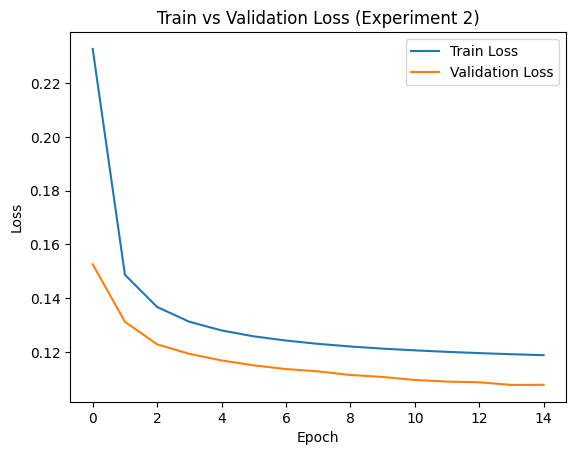

In [13]:
# Graficar las pérdidas
plt.plot(train_losses_exp2, label='Train Loss')
plt.plot(val_losses_exp2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Experiment 2)')
plt.legend()
plt.show()




### Guardamos modelo del experimento 2

In [14]:
torch.save(model.state_dict(), "C://Users//Victor//deep_ocean//TFG_victor//saved_models//modelo_aurora_experimento_2.pth")
torch.save(results_exp2, "C://Users//Victor//deep_ocean//TFG_victor//results//results_exp2.pth")

# **Resultados del Entrenamiento**

- **Train Loss**:  
  - Comienza cerca de `0.2328` en la primera época.  
  - Desciende de manera progresiva hasta `0.1188` al final de la época 15.  
  - Esto sugiere que el decodificador se ajusta satisfactoriamente a lo largo de los pasos de entrenamiento.

- **Validation Loss**:  
  - Inicia aproximadamente en `0.1526` y va decreciendo hasta `0.1078`.  
  - Mantiene una tendencia en línea con la Train Loss, indicando que no se observa sobreajuste drástico.

- **Validation RMSE**:  
  - Baja desde `0.2117` a aproximadamente `0.1342`, lo que revela una **mejora constante** en la predicción de `thetao` sobre la validación.

El gráfico de **Train vs Validation Loss** muestra un descenso sostenido en ambas curvas, con valores cercanos entre entrenamiento y validación, reforzando la idea de que el decodificador puede afinar sus parámetros sin sobreajustarse.

---

# **Conclusión**

Congelar la mayoría de la red y entrenar únicamente el decodificador con un *learning rate* de `1e-4* durante 15 épocas resulta en:

1. Un **ajuste efectivo** del decodificador (reflejado en la disminución tanto de la pérdida de entrenamiento como de validación).  
2. Una **reducción del RMSE** que sugiere una ganancia en precisión en la predicción de `thetao`.  
3. Una **metodología eficiente** de transfer learning, al aprovechar el cuerpo de la red previamente entrenado y refinar únicamente la capa de salida.

Este procedimiento ofrece la ventaja de **reducir costos computacionales**, evitando recalcular gradientes en gran parte de la red y concentrándose en la parte final del modelo. Con más épocas o con un ajuste más detallado de hiperparámetros, se podría lograr una convergencia todavía más fina en la predicción de `thetao`.